# Function approximation using genetic algorithms

## I- Initialization

### Import libraries

In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Performance
import time
from tqdm.notebook import tqdm

### Upload data


In [5]:
def upload(name):
    """
    Upload the data

    Parameters
    ----------
    name: str
          file name (or path)
    Returns
    -------
    temp: pandas.core.frame.DataFrame
          the temperature dataframe
    """
    temp = pd.read_csv(name,sep=";")
    temp.rename(columns={"#i": "i"}, inplace=True)
    return temp

In [6]:
temp = upload(r"temperature_sample.csv")
temp.head(3)

,i,t
0,1.933,0.504
1,0.015,1.209
2,1.879,1.186


## II- Class and methods

### Help functions

In [10]:
def convert2binary(nb, max = 20):
    """
    Convert a number to binary

    Parameters
    ----------
    nb: int
        the number to convert
    max: int
        the max number of bits
    Returns
    -------
    binary: str
            the binary number
    """
    nb = bin(nb).split("b")[1]
    while len(nb) < len(bin(max).split("b")[1]):
      nb = "0" + nb
    return nb

def t(i,a,b,c):
    """
    Function to calculate the temperature

    Parameters
    ----------
    i: int
      the time
    a: float
      the a coefficient
    b: float
      the b coefficient
    c: float
      the c coefficient
    Returns
    -------
    t: float
        the temperature
    """
    return [np.sum([np.cos((np.pi)*k*(b**n))*(float(a)**n) for n in range(c)]) for k in i]

def accuracy_method(a,b,c):
    """
    Calculate the accuracy of the method

    Parameters
    ----------
    a: float
        the a coefficient
    b: float
        the b coefficient
    c: float
        the c coefficient
    Returns
    -------
    accuracy: float 
              the accuracy
    """
    return sum(np.abs(t(temp["i"],a,b,c) - temp["t"]))/sum(np.abs(temp["i"]))*100

### Individual 

In [11]:
class individual:
    """
    Class to create an individual
    """
    def __init__(self, a=None, b=None, c=None, bin=None):
        """
        Initialize the individual

        Parameters
        ----------
        a: float
            the a coefficient (default = None) if a is None, a random value is chosen
        b: float
            the b coefficient (default = None) if b is None, a random value is chosen
        c: float
            the c coefficient (default = None) if c is None, a random value is chosen
        bin: str
            the binary number (if you want to initialize the individual with a binary number)
        """
        self.bin = None

        if a != None and b != None and c != None:
            self.a, self.b, self.c = a, b, c
        elif a != None and bin != None and len(bin) == 10:
            # Convert the binary number to decimal
            self.a, self.bin = a, bin
            self.b, self.c = int(bin[:5],2), int(bin[5:],2)
        else:
            self.a, self.b, self.c = random.uniform(0,1), random.randint(1, 21), random.randint(1, 21)      

        if self.bin == None:
            # Convert the decimal number to binary
            self.bin = convert2binary(self.b) + convert2binary(self.c)
        self.accuracy = self.fitness()
        
    def __str__(self):
        """
        Print the individual
        """
        return f"[{self.a} {self.b} {self.c}]"

    def __eq__(self, autreIndividu):
        """
        Compare two individuals
        """
        return self.a == autreIndividu.a and self.b == autreIndividu.b and self.c == autreIndividu.c
    
    def fitness(self):
        """
        Calculate the fitness of the individual: mean squared error

        Returns
        -------
        fitness: float
                  the fitness value
        """
        self.accuracy = np.linalg.norm(t(np.array(temp["i"]), self.a, self.b, self.c) - temp["t"])
        return self.accuracy

    def display_individu(self):
        """
        Display the individual
        """
        plt.figure(figsize=(10, 5))
        i = np.arange(0, 4.7, 0.0005)
        plt.grid()
        plt.plot(i, t(i,self.a, self.b, self.c), c="b", linewidth=0.5)
        plt.scatter(temp["i"], temp["t"], c='r',s=10)

### Selection, crossovers and mutations

In [12]:
def binary_mutation(parent,nb=4):
    """
    Mutate the binary number of the individual

    Parameters
    ----------
    parent: individual
            the individual to mutate
    nb: int
        the number of bits to mutate
    Returns
    -------
    child: individual
           the mutated individual
    """
    pm = random.uniform(0,1)
    um = random.uniform(0,1)
    if um < pm:
        rank = []
        while len(rank) < nb:
            val = random.randint(0,len(parent))
            while val in rank:
                val = np.random.randint(0,len(parent))
            rank.append(val)
        parent_modified = ""
        for i in range(len(parent)):
            if i in rank:
                parent_modified += "0" if parent[i] == "1" else "1"
            else:
                parent_modified += parent[i]
        return parent_modified
    return parent

def real_mutation(parent):
    """
    Mutate the real number of the individual

    Parameters
    ----------
    parent: individual
            the individual to mutate  
    Returns
    ------- 
    child: individual
            the mutated individual
    """
    mutation_prob=random.randint(0,10)
    if mutation_prob < 3:
        vary = 1 + random.uniform(-0.05, 0.05)
        rem = parent*vary
        if abs(rem) <= 10:
            parent = rem
    return parent

def binary_crossover(parent1,parent2):
    """
    Crossover the binary number of the individuals
    
    Parameters
    ----------
    parent1: individual
              the first individual to crossover
    parent2: individual
              the second individual to crossover
    Returns
    -------
    child1: individual  
            the first child of the crossover
    child2: individual
            the second child of the crossover
    """
    p1 = random.randint(0, 10)
    p2 = random.randint(0, 10)
    while p2 == p1:
        p2 = random.randint(0, 10)
    p1,p2 = min(p1,p2),max(p1,p2)
    child1 = parent1[0:p1]+parent2[p1:p2+1]+parent1[p2+1:10]
    child2 = parent2[0:p1]+parent1[p1:p2+1]+parent2[p2+1:10]
    return child1, child2

def real_crossover(parent1,parent2,eta=2): 
  """
  Crossover between two real numbers based on simulated binary crossover (SBX)
  eta = 2 => more variation between parents
  eta = 5 => less variation between parents

  Parameters 
  ----------
  parent1: float
           the first parent
  parent2: float
           the second parent
  eta: float
       the crossover rate (default = 2)
       Returns
       -------
       child1: float
       """
  u = random.uniform(0,1)
  beta = (2*u)**(1/(eta+1)) if u<=0.5 else (1/(2*(1-u)))**(1/(eta+1))
  child1 = 0.5*((1+beta)*parent1 + (1-beta)*parent2)
  child2 = 0.5*((1-beta)*parent1 + (1+beta)*parent2)
  return child1, child2

In [13]:
def generate_pop(count):
    """
    Generate a population of individuals
    
    Parameters
    ----------
    count: int
           the number of individuals to generate
    Returns
    -------
    population: list
                the generated population 
    """
    return [individual() for i in range(count)]

def evaluate(pop):
    """ 
    Evaluate the population with the fitness function

    Parameters
    ----------
    pop: list
          the population to evaluate
    Returns
    -------
    pop: list 
        the evaluated population sorted by fitness value
    """
    return sorted(pop, key=individual.fitness)

def selection(pop, hcount, lcount):
    """
    Select the best and worst individuals from the population
    In fact, elitism is not the best way to do selection.
    I combined the best and worst individuals to create a new population and avoid the elitism.

    Parameters
    ----------
    pop: list
          the population to select from
    hcount: int
            the number of best individuals to select
    lcount: int
            the number of worst individuals to select
    Returns
    -------
    pop: list
        the selected population
    """
    return pop[:hcount] + pop[-lcount:]

def crossover(parent1, parent2):
    """
    Crossover between two individuals
    Combined the crossover of binary and real numbers

    Parameters
    ----------
    parent1: individual
              the first parent
    parent2: individual 
              the second parent
    Returns
    -------
    children: list
                the list of children
    """
    e1_a, e2_a = real_crossover(parent1.a, parent2.a)  
    e1_binaire, e2_binaire = binary_crossover(parent1.bin, parent2.bin)
    children = [individual(a = e1_a, bin = e1_binaire), individual(a = e2_a, bin = e2_binaire)]
    return children

def mutation(parent):
    """
    Mutate the individual
    Combined the mutation of binary and real numbers

    Parameters
    ----------
    parent: individual
            the individual to mutate
    Returns
    -------
    child: individual
           the mutated individual
    """
    child = individual(a = real_mutation(parent.a), bin = binary_mutation(parent.bin))
    return child

## III- Main loop

In [14]:
def genetic_algorithm(threshold, pop_size, repartition=[10/30,4/30]):
    """
    The main algorithm of the genetic algorithm
    Parameters
    ----------
    threshold: float
                the threshold of fitness (MSE) value to reach
    pop_size: int
              the population size
    repartition: list
                  the repartition of the best and worst individuals
    Returns
    -------
    best_individual: individual
                      the best individual found
    """
    pop = generate_pop(pop_size)
    nbriteration=0
    history = []
    solution_trouvee = False
    while not solution_trouvee:
        nbriteration+=1

        evaluation = evaluate(pop)
        history.append(evaluation[0].accuracy)

        if evaluation[0].accuracy < threshold:
            solution_trouvee = True

        print("\riteration numéro :", nbriteration, "- Fitness:", evaluation[0].accuracy, end="")

        select = selection(evaluation, int(repartition[0] * pop_size), int(repartition[1] * pop_size))
        croises = []
        for i in range(0, len(select)//2):
            croises += crossover(random.choice(select),random.choice(select))
        mutes = []
        for i in range(len(select)):
            mutes.append(mutation(select[i]))
        newalea = generate_pop(pop_size - int(repartition[0]*pop_size) - int(repartition[1]*pop_size))

        pop=select[:]+croises[:]+mutes[:]+newalea[:]

    evaluation = evaluate(pop)
    best_ind = evaluation[0]
    return history, best_ind, nbriteration

## IV- Results 

iteration numéro : 11 - Fitness: 0.181266787099438725.77875 seconds - 11 itérations
0.34160174945401184 15 3 0.18126678709943872
4.107131818292112


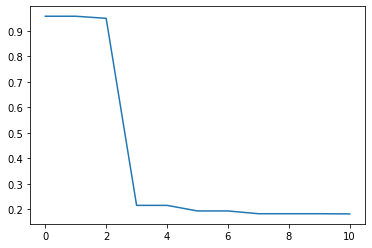

In [15]:
debut = time.process_time()
history, best_ind, nb_iter= genetic_algorithm(0.1813,100)
diff = time.process_time()-debut

print(f"{round(diff,5)} seconds - {nb_iter} itérations")
print(best_ind.a, best_ind.b, best_ind.c, best_ind.accuracy)
print(accuracy_method(best_ind.a, best_ind.b, best_ind.c))

plt.plot(history)
plt.show()

## V- Stats of the algorithm

iteration numéro : 14 - Fitness: 0.181280300855203642.06229 seconds - 14 iterations
0.34110343340928606 15 3 0.18127283866391258
4.10797114472576
iteration numéro : 38 - Fitness: 0.181268923634312436.11695 seconds - 38 iterations
0.3412670124420692 15 3 0.18126892363431243
4.107696235794025
iteration numéro : 670 - Fitness: 0.18127898598126382108.05441 seconds - 670 iterations
0.34203473414009666 15 3 0.18127574119923248
4.106398028541289
iteration numéro : 304 - Fitness: 0.1812750136001254350.46004 seconds - 304 iterations
0.34124202482952964 15 3 0.18126939975060619
4.107738268340406
iteration numéro : 78 - Fitness: 0.1812673168563913613.542 seconds - 78 iterations
0.34166962309197063 15 3 0.18126731685639136
4.107017067886586
iteration numéro : 83 - Fitness: 0.1812670306110985613.33485 seconds - 83 iterations
0.3414117937086637 15 3 0.18126703061109856
4.1074524196527245
iteration numéro : 540 - Fitness: 0.1812674498483646388.47386 seconds - 540 iterations
0.34168212413686994 15 3 0

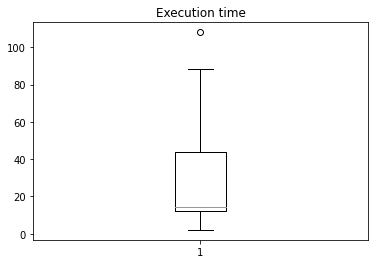

In [19]:
val = []
for i in range(10):
  debut = time.process_time()
  history, best_ind, nb_iter= genetic_algorithm(0.1813,30)
  diff = time.process_time()-debut

  print(f"{round(diff,5)} seconds - {nb_iter} iterations")
  print(best_ind.a, best_ind.b, best_ind.c, best_ind.accuracy)
  print(accuracy_method(best_ind.a, best_ind.b, best_ind.c))
  val.append(diff)
print(val)
print(np.mean(val))
plt.boxplot(val)
plt.title("Execution time") 
plt.show()

## VI- Export predictions

In [ ]:
def generate_download_file(a,b,c):
    """
    Generate a csv file to download that contains the predictions
    """
    with open("flavien_deseure--charron.txt","w") as file:
        file.write(f"{a};{b};{c}")

In [ ]:
generate_download_file(best_ind.a, best_ind.b, best_ind.c)